[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/blhuillier/STAR_2025_GP/blob/main/Notebooks/GP_solution.ipynb
)

# Gaussian Process Regression

In this notebook, we will  implement a simple GP and apply it to a basic data set

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Generate Dataset

In [2]:
# generate data

aa = 1
bb = 1
kk = 1

def func(xx,aa=1,bb=1,kk=1):
  return aa*xx + bb + np.sin(kk*xx)

NN = 30
seed = 0
r = np.random.RandomState(seed)

XX = r.uniform(0,10,size=NN)
print (XX)

# Noise
sigma = 1
noise = sigma*r.randn(NN)
# data
YY = func(XX)+noise
# Test points:
nstar = 201
Xstar = np.linspace(0,10,num=nstar)


[5.48813504 7.15189366 6.02763376 5.44883183 4.23654799 6.45894113
 4.37587211 8.91773001 9.63662761 3.83441519 7.91725038 5.2889492
 5.68044561 9.25596638 0.71036058 0.871293   0.20218397 8.32619846
 7.78156751 8.70012148 9.78618342 7.99158564 4.61479362 7.80529176
 1.18274426 6.39921021 1.43353287 9.44668917 5.21848322 4.1466194 ]


Text(0, 0.5, 'y')

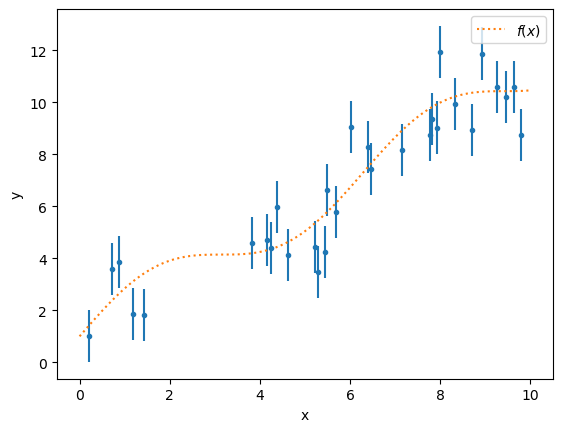

In [3]:
fig,ax = plt.subplots(1)
ax.errorbar(XX,YY,yerr=sigma,ls='',marker='.')
ax.plot(Xstar,func(Xstar),ls=':',label='$f(x)$')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

# Create a Kernel Class

For now, let's just use the squared exponential 


* We need a constructor method: \_\_init\_\_(self, sigma_f, lf)  
* A k(self,x1,x2) method

We need to make x1(n1,1) and x2(1,x2), so taht k(x1,x2) has shape (n1,n2)

In [ ]:
class Kernel():
  def __init__(self,sigma_f,lf):
    """Initialize the kernel with parameters sigma_f and lf.
    """
    self.lf = lf
    self.sigma_f = sigma_f

  def k(self,x1,y2):
    """Compute the kernel function between two sets of inputs.

    Args:
        x1 (np.float or np.ndarray): argument 1
        y2 (np.float or np.ndarray): argument 2
    """
    if np.isscalar(x1):
      x1 = np.array([[x1]])[:,np.newaxis]
    n1,n11 = x1.shape
    assert n11 == 1, "x1 should be a column vector"

    if np.isscalar(y2):
      y2 = np.array([[y2]])[np.newaxis,:]
    n22, n2 = y2.shape
    assert n22 == 1, "y2 should be a column vector" 
    return self.sigma_f**2 * np.exp(-.5*(x1-y2)**2/self.lf**2)




# Create a GP class

In [8]:
class GP():
  def __init__(self,x,y,sigma,kernel):
    self.x = x
    self.y = y
    self.sigma = sigma
    self.kernel = kernel
    self.n = len(x)
    return

  def do_regression(self,xstar,mean=0,meanstar=0):
    '''Perform the actual GP regression
    input:
    xstar: test points
    kernel: Kernel isntance
    mean: prior mean function (m(x))
    meanstar: prior mean function m*(x*)
    '''
    nstar = len(xstar)
    # this has sahpe (n,n)
    KK = self.kernel.k(
        self.x[:,np.newaxis],
        self.x[np.newaxis,:]
      )


    # This has shape (n*,n)
    Kstar = self.kernel.k(
        Xstar[:,np.newaxis],
        self.x[np.newaxis,:]
    )

    # This has shape (n*,n*)
    Kstarstar = self.kernel.k(
        Xstar[:,np.newaxis],
        Xstar[np.newaxis,:]
    )
    # This is K+sigma^2 I:
    KC = KK + sigma**2*np.eye(NN)
    LL = np.linalg.cholesky(KC)
    # print(LL)
    alpha = np.linalg.solve(
        LL.T,
        np.linalg.solve(LL,YY)
    )


    self.fstar = Kstar@alpha
    # vv = np.linalg.solve (Kstar,LL)

    vv = np.array([np.linalg.solve(LL,Kstar[ii,:]) for ii in range(nstar)])
    self.Cstar = Kstarstar - vv@vv.T
    self.sigmastar = np.sqrt(np.diag(self.Cstar))

    self.LML = -.5*YY.T@alpha - np.linalg.slogdet(LL)[1] - NN/2*np.log(2*np.pi)
    
    # sigmaf: 2, lf: 2: LML: -68.24408191515852
    # lf = 0.5: LML = -93.14685243016704



# Perform the Regression

In [9]:
# Data Covariance
sigma_f = 2
lf = 2
K = Kernel(sigma_f,lf)

In [10]:

gp = GP(x=XX,y=YY,sigma=sigma,kernel=K)
gp.do_regression(xstar=Xstar)
fstar = gp.fstar
Cstar = gp.Cstar
sigmastar = np.sqrt(np.diag(Cstar))

# Plot the results

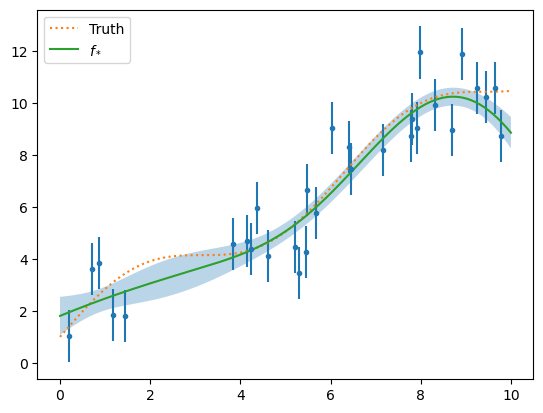

In [11]:

fig,ax = plt.subplots(1)
ax.errorbar(XX,YY,yerr=sigma,ls='',marker='.')
ax.plot(Xstar,func(Xstar),ls=':',label='Truth')
ax.plot(Xstar,fstar,label='$f_*$')
ax.fill_between(Xstar,fstar+sigmastar,fstar-sigmastar,alpha=.3)
ax.legend()